This notebook contains the exercises for the second part of the Autumn School lecture on "Large Scales".

### Preliminaries

This is a Jupyter notebook, which allows you to run Python code in cells. Other cells may contain explanatory text written in Markdown. The exercises are designed so that you can hopefully work through them with only minimal Python knowledge. I provided some hints in case you get stuck.

To get started, we first need to load a selection of Python packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as co
import seawater as sw
import seaborn as sns
sns.set_context(context='paper', font_scale=1.5)

### Model Data and Observation Data

Now we can load some model data and plot them.
This is a section across the Weddell Sea continental slope from a global MITgcm simulation at **horizontal resolution of 1/3°**. 

Additionally, we have some observation data from the same location.

In [3]:
mod = xr.open_dataset('model.nc')
obs = xr.open_dataset('obs.nc')

# and some precomputed neutral density
gamma_mod = xr.open_dataarray('gamma_mod.nc')
gamma_obs = xr.open_dataarray('gamma_obs.nc')

All the data you need are contained in the xarray datasets ```mod``` and ```obs```. Variables can be accessed by using dataset.var, for example temperature: ```mod.THETA```


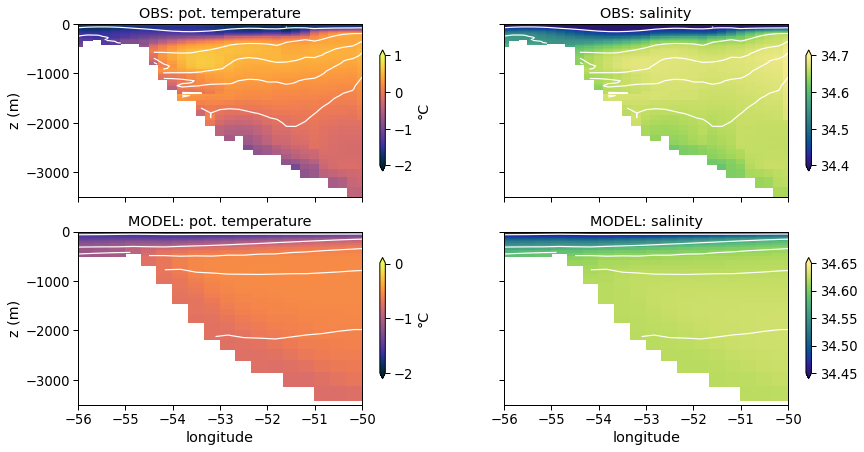

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[14,7], sharex='all', sharey='all')

o1 = axes[0,0].pcolormesh(obs.X, -obs.Depth, obs.TMP, vmin=-2, vmax=1, cmap=co.cm.thermal, shading='auto')
axes[0,0].contour(obs.X, -obs.Depth, gamma_obs, levels=[27.7, 27.8, 27.82, 27.83, 27.84], colors='w')
axes[0,0].set_ylim(-3500,0)
axes[0,0].set_xlim(-56, -50)
axes[0,0].set_ylabel('z (m)')
axes[0,0].set_title('OBS: pot. temperature')

o2 = axes[0,1].pcolormesh(obs.X, -obs.Depth, obs.SAL, vmin=34.4, vmax=34.7, cmap=co.cm.haline, shading='auto')
axes[0,1].set_title('OBS: salinity')
axes[0,1].contour(obs.X, -obs.Depth, gamma_obs, levels=[27.7, 27.8, 27.82,  27.83, 27.84], colors='w')

m1 = axes[1,0].pcolormesh(mod.XC, mod.Z, mod.THETA, vmin=-2, vmax=.01, cmap=co.cm.thermal, shading='auto')
axes[1,0].contour(mod.XC, mod.Z, gamma_mod, levels=[27.7, 27.8, 27.82,  27.83, 27.84], colors='w')
axes[1,0].set_xlabel('longitude')
axes[1,0].set_ylabel('z (m)')
axes[1,0].set_title('MODEL: pot. temperature')

m2 = axes[1,1].pcolormesh(mod.XC, mod.Z, mod.SALT, vmin=34.45, vmax=34.65, cmap=co.cm.haline, shading='auto')
axes[1,1].contour(mod.XC, mod.Z, gamma_mod, levels=[27.7, 27.8, 27.82,  27.83, 27.84], colors='w')
axes[1,1].set_xlabel('longitude')
axes[1,1].set_title('MODEL: salinity')

plt.colorbar(o1, ax=axes[0,0], extend='both', shrink=.7, label=('°C'))
plt.colorbar(m1, ax=axes[1,0], extend='both', shrink=.7, label=('°C'))
plt.colorbar(o2, ax=axes[0,1], extend='both', shrink=.7)
plt.colorbar(m2, ax=axes[1,1], extend='both', shrink=.7);


### Exercise 1: Model vs. Observations

1. What **qualitative differences** do you observe between the model and the observations (be careful with the adjusted colorbars)?

- smaller range of temperatures/salinities
- straighter isopycnals 
- weaker dense water signal

2. Where might these differences originate? Speculate on possible causes.

- unresolved eddies
- representation of the cryosphere

3. Looking at the isoycnals (contours), did the eddy parameterization ($\kappa_{GM, Redi} = const = 200 m^2/s$) do a good job? Can you suggest an improvement?

Isopycnals look too "flat", suggesting that the influence of the eddy parameterization was too strong. The GM/Redi coefficients could be reduced, for example by making them a function of the topographic slope (eddy suppression). 

### Exercise 2: Rossby radius and resolution

The **first baroclinic Rossby radius** gives a characteristic eddy length scale and therefore an estimate of the horizontal resolution required to resolve mesoscale eddies.
Compute the first baroclinic Rossby radius for the given section. Based on the result, do you expect this model configuration to resolve eddies over the Antarctic continental slope?

Some **Hints**:

The code for plotting the model fields above should give you an idea of how to access and plot the model data.

The seawater library contains many useful functions. For example, the pressure can be computed as follows:

In [11]:
p = sw.pres(-mod.Z, -65)

### now bring it to the same shape as T and S
p = np.tile(p, [20, 1]).T

The bouyancy frequency can be computed with (typing a ? after a function and running the cell gives you further information on how the function works):

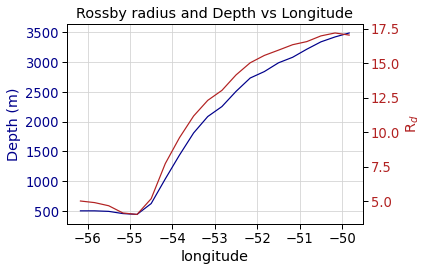

In [34]:
N_sq,_,_ = sw.bfrq(mod.SALT, mod.THETA, p)
N = np.nanmean(np.sqrt(N_sq),0)
R_d = N*mod.Depth/np.pi/1.3e-4/1e3

fig, ax1 = plt.subplots()

ax1.set_xlabel('longitude')
ax1.set_ylabel('Depth (m)', color='darkblue')
ax1.plot(mod.XC, mod.Depth, color='darkblue', label='Depth')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.grid(c='lightgrey')

ax2 = ax1.twinx()
ax2.set_ylabel('R$_d$', color='firebrick')
ax2.plot(mod.XC, R_d, color='firebrick', label='R$_d$')
ax2.tick_params(axis='y', labelcolor='firebrick')

plt.title('Rossby radius and Depth vs Longitude')
fig.tight_layout()
plt.show()

A degree longitude at 65° S roughly corresponds to 50 km, but we need several grid points per eddy. Assuming 3 grid points per eddy and taking the smallest Rossby Radiu, a grid spacing of 1/3° is not enough to resolve eddies. We would need something like 1/45°.

<details>
<summary> <b> More Hints</b> </summary>

- The water depth can be found in mod.Depth
- a mean excluding nans can be done with np.nanmean(x, dimension)
- a line plot can be produced with plt.plot(x,y)
    
</details>

### Exercise 3: Computational Cost

Tests on an HPC system suggest that running the global model at a grid spacing of 1/3° for one simulated year requires roughly **8.5 node hours**. Using your result from Exercise 2, **estimate the computational cost of running the model at eddy-resolving resolution for 100 years.**  
Finally, **compare the CO₂ emissions from a 100-year run at the two resolutions with the emissions from round-trip flight between London and New York.**

<details>
<summary> <b> Hints</b> (from the ARCHER2 HPC manual)</summary>

- Cost of 1 node hour = £0.20  
- CO₂ emissions of 1 node hour = 23 g
    
</details>

The computational cost increase to move from 1/3° to 1/30° is 10$^3$. 

The cost would be:

In [46]:
8.5 * 15**3 * 100 * 0.2

573750.0

The carbon emmission would be:

In [47]:
8.5 * 15**3 * 100 * 0.023 / 1e3

65.98125

... or more than 30 round-trip flights.

### Exercise 4: Slope criteria for gravity currents
    
Is the horizontal and vertical grid spacing sufficient to resolve gravity currents? How do the required resolutions compare to the one necessary to resolve eddies?

<details>
<summary> <b>Hints</b></summary>

- Plumes are well-resolved if $R_v < H/2$ and $R_h < R_v/\alpha$
- Observations suggest a plume thickness of roughly H = 300 m
- The water depth can be found in mod.Depth
- The length of a grid cell can be found in mod.dxC
- The vertical grid spacing can be found in mod.drF
- Values of xarray data arrays can be printed by adding .compute()
    
</details>

$\Delta z_c$ = H/2 = 150 m
$\Delta x_c$ = 150m / 0.01 = 15 km

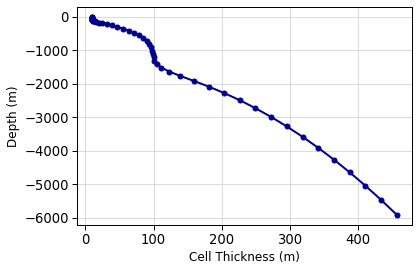

In [45]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(mod.drF, mod.Z, color='darkblue', linewidth=2, marker='o', markersize=5)

ax.set_xlabel('Cell Thickness (m)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)

# Grid and style adjustments
ax.grid(c='lightgrey')

plt.show()